In [1]:
import numpy as np
import matplotlib.pyplot as plt

RANGE = 6
SAMPLES = 15
ALPHA_TIME = 2.5 # total_time = SUM(ALPHA_TIME * dist_{i,i+1})
SEED = 28

Genero una serie de puntos aleatorios

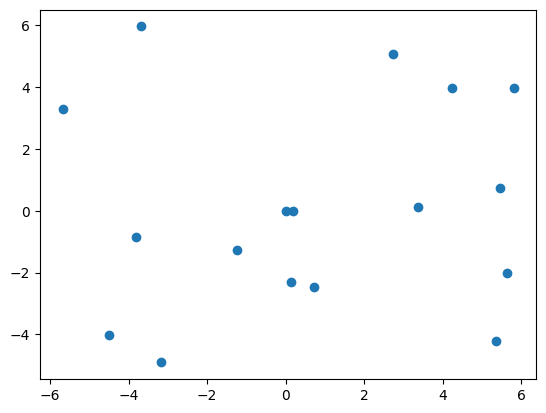

In [2]:
np.random.seed(SEED)
xs = np.concatenate([[0, 0.2], np.random.uniform(-RANGE, RANGE, SAMPLES)])
ys = np.concatenate([[0, 0], np.random.uniform(-RANGE, RANGE, SAMPLES)])
plt.scatter(xs, ys)

Calculo la secuencia mas corta para recorrerlos

Vease https://developers.google.com/optimization/routing/tsp

In [3]:
def create_data_model(x, y):
    """Stores the data for the problem."""
    data = {}
    data["locations"] = list(zip(x, y))
    data["distance_matrix"] = np.zeros((len(data["locations"]), len(data["locations"])))
    for i in range(len(data["locations"])):
        for j in range(len(data["locations"])):
            data["distance_matrix"][i][j] = np.linalg.norm(np.array(data["locations"][i]) - np.array(data["locations"][j]))
    data["num_vehicles"] = 1
    data["depot"] = 0
    return data

In [4]:
from ortools.constraint_solver import pywrapcp, routing_enums_pb2

data = create_data_model(xs, ys)
manager = pywrapcp.RoutingIndexManager(
    len(data["distance_matrix"]), data["num_vehicles"], data["depot"]
)
routing = pywrapcp.RoutingModel(manager)

In [5]:
def distance_callback(from_index, to_index, manager=manager, data=data):
    """Returns the distance between the two nodes."""
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return int(data["distance_matrix"][from_node][to_node])

transit_callback_index = routing.RegisterTransitCallback(distance_callback)

# Funcion objetivo
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

In [6]:
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
)
search_parameters.local_search_metaheuristic = (
    routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
)
search_parameters.time_limit.FromMilliseconds(1000)

# Solve the problem.
solution = routing.SolveWithParameters(search_parameters)

In [7]:
def print_solution(manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()}")
    index = routing.Start(0)
    plan_output = "Route for vehicle 0:\n"
    route_distance = 0
    while not routing.IsEnd(index):
        plan_output += f" {manager.IndexToNode(index)} ->"
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
    plan_output += f" {manager.IndexToNode(index)}\n"
    plan_output += f"Route distance: {route_distance/1000}\n"
    print(plan_output)

In [8]:
solution = routing.SolveWithParameters(search_parameters)
if solution:
    print_solution(manager, routing, solution)

Objective: 39
Route for vehicle 0:
 0 -> 1 -> 6 -> 16 -> 13 -> 10 -> 11 -> 9 -> 2 -> 12 -> 15 -> 8 -> 4 -> 14 -> 3 -> 7 -> 5 -> 0
Route distance: 0.039



In [9]:
def get_routes(solution, routing, manager):
    """Get vehicle routes from a solution and store them in an array."""
    # Get vehicle routes and store them in a two dimensional array whose
    # i,j entry is the jth location visited by vehicle i along its route.
    routes = []
    time = [0]
    for route_nbr in range(routing.vehicles()):
        index = routing.Start(route_nbr)
        location_index = manager.IndexToNode(index)
        route = [data["locations"][location_index]]
        while not routing.IsEnd(index):
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            location_index = manager.IndexToNode(index)
            route.append(data["locations"][location_index])
            time.append(time[-1] + ALPHA_TIME * data['distance_matrix'][previous_index][location_index])
        routes.append(route)
    return np.array(routes[0]), np.array(time)

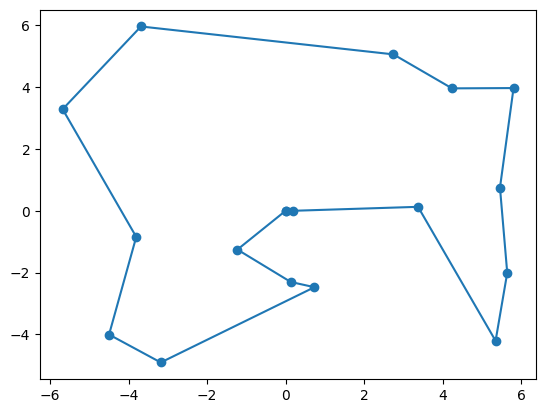

In [10]:
data['locations_sorted'], data['time_sorted'] = get_routes(solution, routing, manager)

plt.plot(data['locations_sorted'][:, 0], data['locations_sorted'][:, 1], marker='o')

### Splines
Genero una curva spline que pase por esos puntos en ese orden

#### Recorrido exacto (CubicSpline)

In [11]:
from scipy.interpolate import CubicSpline

# Create separate splines for x and y coordinates
cs_x = CubicSpline(data['time_sorted'], data['locations_sorted'][:, 0], bc_type='natural') # f(x(t))
cs_y = CubicSpline(data['time_sorted'], data['locations_sorted'][:, 1], bc_type='natural') # f(y(t))

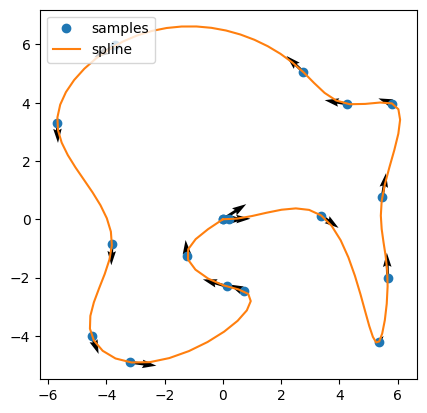

In [12]:
ts_new = np.linspace(0, max(data['time_sorted']), 100)

fig, ax = plt.subplots()
ax.plot(data['locations_sorted'][:, 0], data['locations_sorted'][:, 1], 'o', label='samples')
ax.plot(cs_x(ts_new), cs_y(ts_new), label='spline')
ax.axes.set_aspect('equal')
ax.legend(loc='upper left')

# Derivadas
dxdt = cs_x.derivative()(data['time_sorted'])
dydt = cs_y.derivative()(data['time_sorted'])
ax.quiver(data['locations_sorted'][:, 0], data['locations_sorted'][:, 1], dxdt, dydt)
plt.show()

In [13]:
# calculo los angulos
angles = np.arctan2(dydt, dxdt)
angles

array([-0.01347379,  0.02663947, -0.62011086,  0.89809899,  1.59950135,
        1.41470014,  2.78599567,  2.97632521,  2.37795197, -2.62941577,
       -1.53270964, -1.60070379, -1.2061652 , -0.12751395,  2.7197452 ,
        2.85505436,  1.66499505,  0.57560357])

In [14]:
data['spline_waypoints'] = np.concatenate((data['time_sorted'][:, None], data['locations_sorted'], angles[:, None]), axis=1)
print(data['spline_waypoints'])
data['spline_waypoints'] = data['spline_waypoints'].reshape(-1).round(8).tolist() # Listo para copiar y pegar en el launch

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.34737878e-02]
 [ 5.00000000e-01  2.00000000e-01  0.00000000e+00  2.66394692e-02]
 [ 8.44569625e+00  3.37569848e+00  1.28036817e-01 -6.20110859e-01]
 [ 2.03580327e+01  5.35272412e+00 -4.20739523e+00  8.98098987e-01]
 [ 2.59037535e+01  5.64954122e+00 -2.00905434e+00  1.59950135e+00]
 [ 3.28137051e+01  5.46446271e+00  7.48722858e-01  1.41470014e+00]
 [ 4.09148862e+01  5.81056162e+00  3.97065972e+00  2.78599567e+00]
 [ 4.48359810e+01  4.24215450e+00  3.96083287e+00  2.97632521e+00]
 [ 4.94739417e+01  2.74816491e+00  5.06069822e+00  2.37795197e+00]
 [ 6.57207378e+01 -3.68758831e+00  5.96315149e+00 -2.62941577e+00]
 [ 7.40693645e+01 -5.68375382e+00  3.28597870e+00 -1.53270964e+00]
 [ 8.54123350e+01 -3.80767970e+00 -8.45173997e-01 -1.60070379e+00]
 [ 9.34988042e+01 -4.50039490e+00 -4.00471557e+00 -1.20616520e+00]
 [ 9.74934266e+01 -3.18229974e+00 -4.90790248e+00 -1.27513949e-01]
 [ 1.09025031e+02  7.34875228e-01 -2.47229079e+00  2.71974520e

##### Recorrido aproximado (splprep, splev)
Parametro s: smooth factor

In [15]:
from scipy.interpolate import splprep, splev
tck, u = splprep(data['locations_sorted'].T, s=1)
x_i,y_i= splev(np.linspace(0, 1, 100),tck)

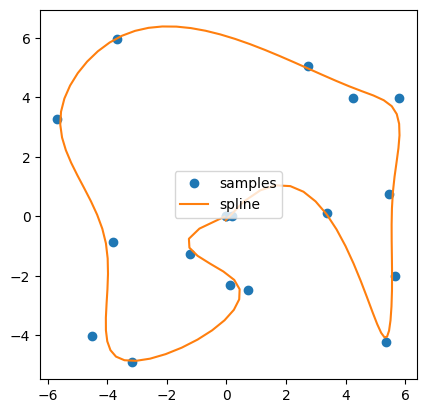

In [16]:
fig, ax = plt.subplots()
ax.plot(data['locations_sorted'][:, 0], data['locations_sorted'][:, 1], 'o', label='samples')
ax.plot(x_i, y_i, label='spline')
ax.axes.set_aspect('equal')
ax.legend(loc='center')
plt.show()

In [17]:
# Idem derivadas y angulos para este caso
u_new = np.linspace(0, 1, len(u))
x_aprox, y_aprox = splev(u_new, tck)
dxdu, dydu = splev(u_new, tck, der=1)
angles_aprox = np.arctan2(dydu, dxdu)
param_aprox = np.linspace(0, max(data['time_sorted']), len(u_new))

waypoints_aprox = np.column_stack((param_aprox, x_aprox, y_aprox, angles_aprox))
print(waypoints_aprox)
data["spline_waypoints_aprox"] = waypoints_aprox.reshape(-1).round(8).tolist()

[[ 0.00000000e+00 -2.65078536e-02 -1.33452808e-01  8.80515692e-01]
 [ 7.01625391e+00  2.92543224e+00  5.69104435e-01 -7.44233441e-01]
 [ 1.40325078e+01  4.65172345e+00 -2.53241984e+00 -1.20829092e+00]
 [ 2.10487617e+01  5.42965228e+00 -3.96812027e+00  1.24109885e+00]
 [ 2.80650156e+01  5.55569312e+00 -1.22556839e+00  1.58507594e+00]
 [ 3.50812696e+01  5.72372626e+00  1.88194732e+00  1.42972607e+00]
 [ 4.20975235e+01  5.30349026e+00  3.89007589e+00  2.61827206e+00]
 [ 4.91137774e+01  2.85944013e+00  4.91413423e+00  2.72181801e+00]
 [ 5.61300313e+01 -1.07546512e-03  6.05238688e+00  2.85011372e+00]
 [ 6.31462852e+01 -2.80580211e+00  6.29752156e+00 -2.93224448e+00]
 [ 7.01625391e+01 -5.05899331e+00  4.71573341e+00 -2.16001682e+00]
 [ 7.71787930e+01 -5.38470599e+00  2.19951297e+00 -1.21243999e+00]
 [ 8.41950469e+01 -4.18624081e+00 -3.60716056e-01 -1.25448873e+00]
 [ 9.12113009e+01 -4.04442832e+00 -3.27323063e+00 -1.61480368e+00]
 [ 9.82275548e+01 -3.23066780e+00 -4.85534041e+00 -4.12620942e